In [1]:
import ingestor, modeller, fitter
import numpy as np
from matplotlib import pyplot as plt


In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', grid=False)
plt.rcParams['figure.figsize'] = [15, 10]

from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [3]:
from importlib import reload

reload(ingestor)
reload(modeller)
reload(fitter)

<module 'fitter' from '/media/dwu402/Data/wrap-mad/fitter.py'>

In [4]:
context_survivors = ingestor.Context("runs/generic_immune_survivors.run")
solver_survivors = fitter.Fitter(context_survivors)

In [5]:
context_nonsurvivors = ingestor.Context("runs/generic_immune_nonsurvivors.run")
solver_nonsurvivors = fitter.Fitter(context_nonsurvivors)

In [6]:
rhos = np.logspace(-6, 5, num=45)

In [7]:
for rhoi in rhos:
    for solver in (solver_survivors, solver_nonsurvivors):
        solver.solve(rhoi)
        for idx, p in enumerate(solver.problems):
            p.initial_guess = solver.solutions[str(rhoi)][idx].x

## Survivors

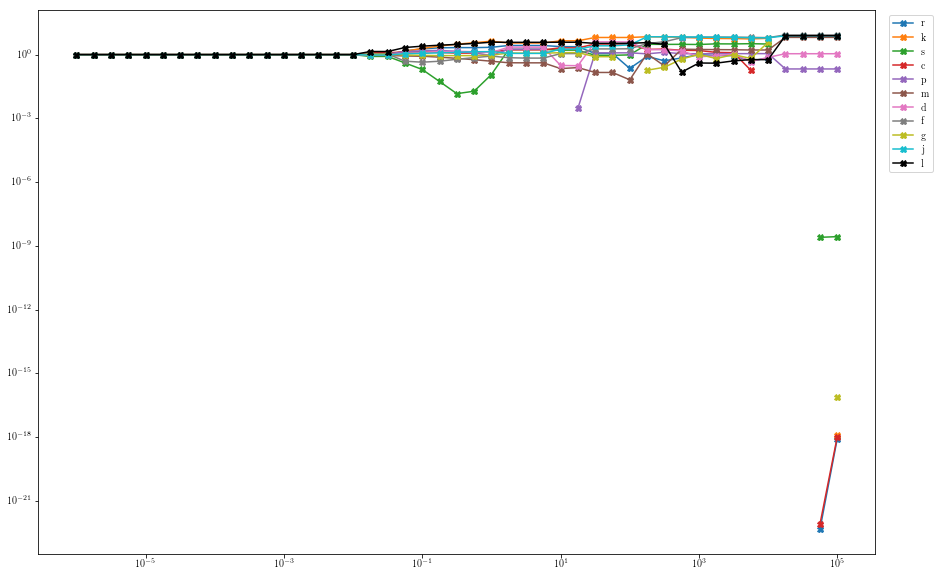

In [27]:
rhoss = [float(rho) for rho in solver_survivors.solutions.keys()]
valss = [val[0].x for val in solver_survivors.solutions.values()]
plt.plot(rhoss, valss, 'X-')
plt.legend("rkscpmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

## Non-survivors

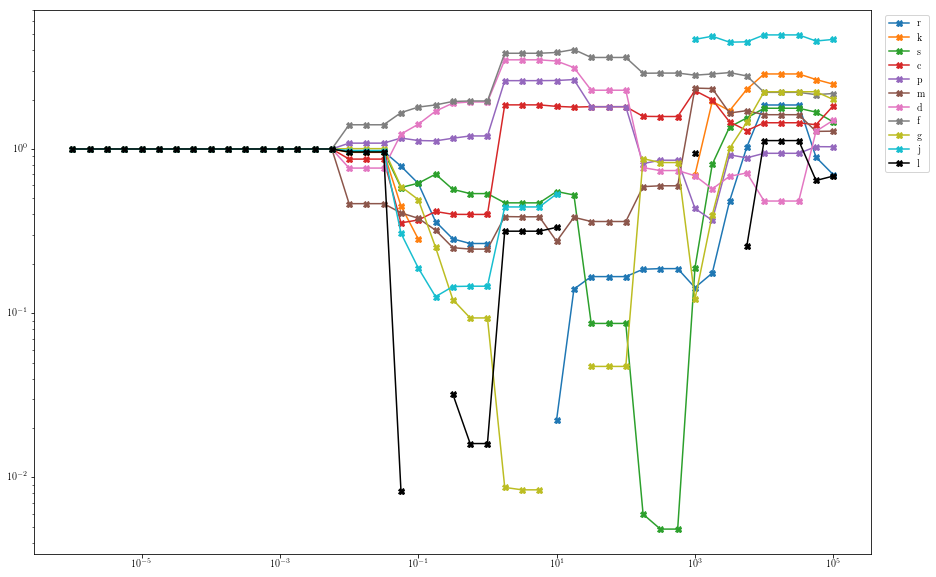

In [11]:
rhosn = [float(rho) for rho in solver_nonsurvivors.solutions.keys()]
valsn = np.array([[v.x for v in val] for val in solver_nonsurvivors.solutions.values()]).reshape(len(rhosn), -1)
plt.plot(rhosn, valsn[:,11:22], 'X-')
plt.legend("rkscpmdfgjl"*3, loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

## Analysis


In [12]:
# determine ideal values for rho (alpha is fixed btw)
def calculate_ideal_rho(idx, context, solver):
    sols = [s[idx] for s in solver.solutions.values()]
    problem = solver.problems[idx]
    pure_f = [s.fun - solver.regularisation(s.x) for s in sols]
    dfield = [problem.cache.results[fitter.tokey(rho, s.x)].fun - f for rho, s, f in zip(rhos, sols, pure_f)]
    ndist = [np.linalg.norm([np.log(f),np.log(d)]) for f,d in zip(pure_f, dfield)]
    return np.argmin(ndist)

In [13]:
def find_x(idx, context, solver, rhoidx):
    c_end = solver.problems[idx].cache.results[fitter.tokey(rhos[rhoidx], solver.solutions[str(rhos[rhoidx])][idx].x)].x
    getx = fitter.ca.Function("getx", [solver.models[idx].ts, *solver.models[idx].cs], solver.models[idx].xs)
    return np.array([np.array(i) for i in getx(solver.models[idx].observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])[:,:,0]
def dfield_x(idx, context, solver, rhoidx, xs_end):
    return np.array([context.model(t, xs_end[:,i], solver.solutions[str(rhos[rhoidx])][idx].x) 
                 for i,t in enumerate(solver.models[idx].observation_times)])

In [14]:
# find ideal parameter estimate for each dataset
for datasetidx, _ in enumerate(solver_survivors.models):
    argidx = calculate_ideal_rho(datasetidx, context_survivors, solver_survivors)
    print(argidx)
    print(rhos[argidx])
    print(solver_survivors.solutions[str(rhos[argidx])][datasetidx].x)

38
3162.2776601683795
[0.89639373 5.70018459 3.19224384 1.23694567 1.11144571 1.70055375
 1.06319016 6.628774   1.00214517 6.48596897 0.50769084]
33
177.82794100389228
[1.51319832 1.54838208 1.24174103 0.95754854 2.40114194 0.73771108
 1.41935657 0.04211699 0.93630472 2.52752523 2.91927519]
39
5623.413251903491
[0.98746613 1.1197602  0.62554895 0.39260339 1.62557272 0.75880186
 1.64636667 1.97120882 2.05976658 2.1580089  0.45752608]


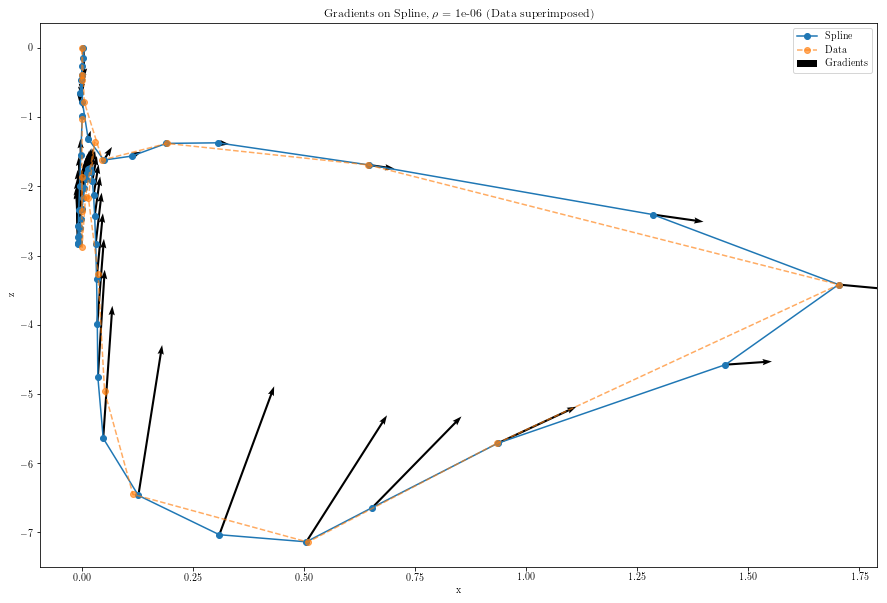

In [24]:
rix = 0
x0 = find_x(0, context_survivors, solver_survivors, rix)
d0 = dfield_x(0, context_survivors, solver_survivors, rix, x0)

plt.plot(x0[0], x0[2], 'o-')
plt.plot(context_survivors.datasets[0]['x'], context_survivors.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(x0[0], x0[2], d0[:,0], d0[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {rhos[rix]} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

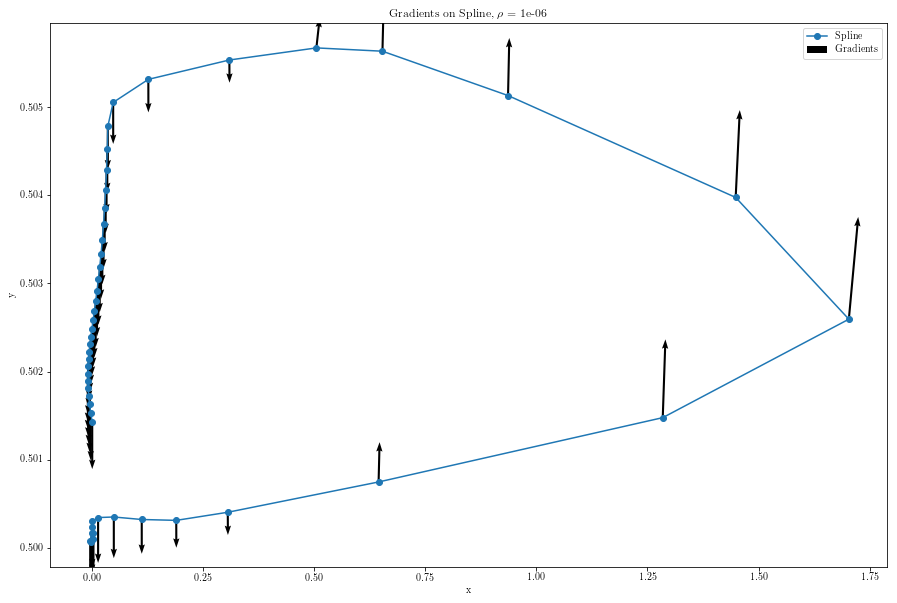

In [25]:
plt.plot(x0[0], x0[1], 'o-')
plt.quiver(x0[0], x0[1], d0[:,0], d0[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {rhos[rix]}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

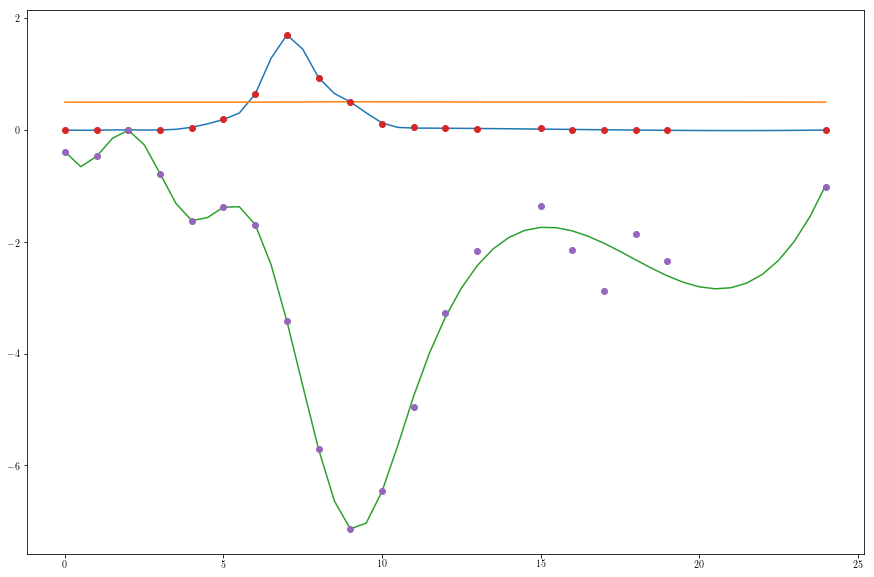

In [26]:
plt.plot(solver_survivors.models[0].observation_times, x0.T)
plt.plot(context_survivors.datasets[0]['t'], context_survivors.datasets[0]['x'], 'o',
         context_survivors.datasets[0]['t'], context_survivors.datasets[0]['z'], 'o')